In [2]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
from time import strptime
import datetime
from datetime import datetime
import warnings
import time
import csv
import glob
import logging
import importlib
from tqdm import tqdm
import json
import networkx as nx
import seaborn as sns
import re
from operator import itemgetter
import matplotlib as mpl 
import matplotlib.cm as mcm
import community
from community import community_louvain as cm
import leidenalg as la
import igraph as ig
from cdlib import algorithms
from tweets_utils import tweets_utils
warnings.filterwarnings('ignore')
path = "C:/Users/gianl/Desktop/Gi/Supsi/BachelorProject/network/"
%autosave 3600

ModuleNotFoundError: No module named 'tweets_utils'

# Indice

- [Functions](#func)

- [Network Community 1](#comm_1)

    - [Info](#info_1)
    - [Louvain](#louvain_1)    


- [Network Community 2](#comm_2)

    - [Info](#info_2)
    - [Louvain](#louvain_2)  


- [Network Community 19](#comm_19)

    - [Info](#info_19)
    - [Louvain](#louvain_19)    
    
    
- [Subnetworks Df](#subnet_df)

- [SAGE](#sage)

### Functions
<a id ="func"/>

In [3]:
def clean_data_format(df: pd.DataFrame, broken_col='name', fix_encoding=False):
    col = df.columns[-1]

    def clean(target):
        return str(target).replace("\r", "")

    if "\r" in col:
        clean_col = clean(col)
        df = df.rename(columns={col: clean_col})
        if df[clean_col].dtype.name == 'object':
            df[clean_col] = df[clean_col].apply(clean)
    if fix_encoding:
        df[broken_col] = df[broken_col].apply(util.fix_encoding)
    return df

In [4]:
def network_general(df, col_1="name", col_2="rt_name"):
    retweets_graph = nx.from_pandas_edgelist(df, col_1 ,col_2 , create_using=nx.DiGraph())
    info = nx.info(retweets_graph)
    
    degree_dict = dict(retweets_graph.degree(retweets_graph.nodes()))
    sorted_degree = sorted(degree_dict.items(), key=itemgetter(1), reverse=True)
    
    in_degree_dict = dict(retweets_graph.in_degree(retweets_graph.nodes()))
    sorted_in_degree = sorted(in_degree_dict.items(), key=itemgetter(1), reverse=True)
    
    out_degree_dict = dict(retweets_graph.out_degree(retweets_graph.nodes()))
    sorted_out_degree = sorted(out_degree_dict.items(), key=itemgetter(1), reverse=True)
    
    return {"info": info, "degree": sorted_degree, "in_degree": sorted_in_degree,  
            "out_degree": sorted_out_degree}

In [5]:
def network_louvain(df, col_1="name", col_2="rt_name"):
    retweets_graph_und = nx.from_pandas_edgelist(df, col_1, col_2)
    info = nx.info(retweets_graph_und)
    
    best_part = cm.best_partition(retweets_graph_und, random_state=42)
    
    return {"info": info, "best_part": best_part}

In [6]:
def rt_community(df, louvain, col="user_screen_name"):
    community = []
    name = []
    rt = []
    for i in df[col]:
        if i in louvain:
            rt.append((i, louvain.get(i)))
    for i in range(len(rt)):
        community.append(rt[i][1])
    val = pd.Series(community)
    val = val.value_counts().sort_values(ascending=False)
    return val

In [7]:
def plot_hist(val, title, col="lightseagreen"):
    fig = plt.figure(figsize=(14, 8))
    ax = val[:10].plot(kind='barh', color=col, fig=(14,14)) #orange #lightseagreen
    ax.set_title(title, fontsize=15)
    ax.invert_yaxis()
    plt.show()

In [8]:
def df_from_degree(degree, lst_subcomm, community, subcomm):
    lst_name = []
    lst_deg = []
    lst_comm = []
    lst_descr = []
    lst_sub = []
    cont = 0
    for i in degree: #primi 50 8
        if cont == 5:
            break
        if i[0] in lst_subcomm:
            cont = cont + 1
            lst_name.append(i[0])
            lst_deg.append(i[1])
            lst_comm.append(community)
            lst_sub.append(subcomm)
    df = pd.DataFrame(list(zip(lst_name, lst_deg, lst_comm, lst_sub)),
                   columns =['name', 'degree', 'community', "subcommunity"])
    return df

### Load Files

In [9]:
def read_from_json(path):
    start_time = time.perf_counter()
    file = open (path,)
    obj = json.loads(file.read())
    file.close()
    stop_time = time.perf_counter()
    print("Time: ",stop_time-start_time)
    return obj

In [10]:
path_ccdh_rt = glob.glob("F:/Supsi/COVID-19-Tweets/large_files/ccdh/")
ccdh_rt = pd.read_csv(path_ccdh_rt[0] + "rt_bad.csv")
good_rt = pd.read_csv(path_ccdh_rt[0] + "rt_good.csv")
path_dozen = glob.glob("C:/Users/gianl/Desktop/Gi/Supsi/BachelorProject/csv/")
bad_dozen = pd.read_csv(path_dozen[0] + "disinformation_users.csv")
good_dozen = pd.read_csv(path_dozen[0] + "good_dozen.csv")
files_tweets = glob.glob("F:/Supsi/COVID-19-Tweets/*/tweets.csv")
sage_path = glob.glob("C:/Users/gianl/Desktop/Gi/Supsi/BachelorProject/sage/data/")
df_sage = pd.read_csv(sage_path[0] + "networks_50.csv", low_memory=False, 
                      lineterminator="\n")

### Network Community 1
<p>

    Community Americana con tendenza politica / giornalistica
    - contiene 4 Good Dozen (DrDenaGrayson, ashishkjha, edyong209, HelenBranswell)
    - contiene utenti che retwettano i Good Dozen

</p>
<a id="comm_1"/>

In [10]:
path_inside = path + "/network_1/"
louvain_path = glob.glob(path_inside + "louvain*.json")[0]
deg_path = glob.glob(path_inside + "degree.json")[0]
degree_1 = read_from_json(deg_path)
louvain_1 = read_from_json(louvain_path)
ccdh_rt_flt_1 = ccdh_rt[ccdh_rt.user_screen_name.isin([x for x in louvain_1])]
good_rt_flt_1 = good_rt[good_rt.user_screen_name.isin([x for x in louvain_1])]

Time:  2.046259299999747
Time:  1.494698900000003


In [13]:
nt_1_users = list(louvain_1.keys())

In [34]:
result = []
importlib.reload(tweets_utils)
start_time = time.perf_counter()
j = 0
df_nt1 = pd.DataFrame()
cols_tweets = ["user_screen_name", "text", "hashtags"]
for filename in tqdm(files_tweets):
    print(f"Reading file: {filename}")
    result.extend(tweets_utils.process_all_data(filename, cols_tweets, True, nt_1_users))
    lista = result[j]
    j = j + 1
    print(f"Mese numero {j}")
    for i in range(len(lista)):
        df_nt1 = df_nt1.append(lista[i]["df"])
stop_time = time.perf_counter()
print("Time: ",stop_time-start_time)

In [15]:
df_nt1 = df_nt1.reset_index(drop=True)
df_nt1

,user_screen_name,text,hashtags
0,Paxman42,Where is our FEDERAL vaccination education cam...,"[{'text': 'lungcancer', 'indices': [103, 114]}]"
1,buysell55555,It's here folks\nA traveller from #China has b...,"[{'text': 'China', 'indices': [53, 59]}, {'tex..."
2,kbplitt,"A man who lives in Snohomish County, Washingto...",[]
3,PDerek56,Deadly new virus in China has reached the U.S....,[]
4,Norberta36,BREAKING from @CNN - CDC expected to announce ...,[]
...,...,...,...
11260659,RverseUncRuckus,@shaunking @JoeBiden Now the left is throwing ...,[]
11260660,someleftyfucker,I’m still stuck on using tear gas in the middl...,[]
11260661,wordbrd,Trump buries detailed CDC advice on reopening ...,[]
11260662,ashsantacruz,What folly! https://t.co/PPPXLTfP6R,[]


In [16]:
df_nt1.to_csv("C:/Users/gianl/Desktop/Gi/Supsi/BachelorProject/sage/data/nt_1_txt.csv", line_terminator="\n",
                  encoding="utf-8", index=False)

#### Info
<a id="info_1"/>

<p>
    
    Graph with 1142470 nodes and 6309017 edges

</p>

#### Louvain
<a id="louvain_1"/>

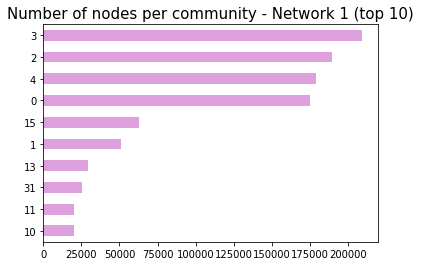

le prime 5 subcommunities sono il 71.32% del totale nella network_1
il numero di utenti è 1142470


In [11]:
communities = []
for i in louvain_1:
    communities.append(louvain_1.get(i))
comm = pd.Series(communities).value_counts().sort_values(ascending=False)
ax = comm[:10].plot(kind='barh', color='plum') #orange #lightseagreen
ax.set_title('Number of nodes per community - Network 1 (top 10)', fontsize=15)
ax.invert_yaxis()
plt.show()
s = 0
for i in comm[:5]:
    s = s + i 
print(f"le prime 5 subcommunities sono il {round(s/comm.sum()*100,2)}% del totale nella network_1")
print(f"il numero di utenti è {comm.sum()}")

### Dozen inside community 1

In [13]:
print("Good dozen: ")
for i in louvain_1:
    if i in list(good_dozen["screen_name"]) or i in list(bad_dozen["screen_name"]):
        print(i)
        print(louvain_1.get(i))

Good dozen: 
DrDenaGrayson
3
ashishkjha
0
edyong209
0
HelenBranswell
0


### Subcommunities

In [81]:
lst_3 = []
lst_0 = []
lst_2 = []
lst_4 = []
lst_15 = []
for i in louvain_1:
    if louvain_1.get(i) == 3:
        lst_3.append(i)
    if louvain_1.get(i) == 0:
        lst_0.append(i)
    if louvain_1.get(i) == 2:
        lst_2.append(i)
    if louvain_1.get(i) == 4:
        lst_4.append(i)
    if louvain_1.get(i) == 15:
        lst_15.append(i)
                

In [82]:
df_info = df_from_degree(degree=degree_1, lst_subcomm=lst_3, community=1, subcomm=3)
df_info = df_info.append(df_from_degree(degree=degree_1, lst_subcomm=lst_0, community=1, subcomm=0))
df_info = df_info.append(df_from_degree(degree=degree_1, lst_subcomm=lst_2, community=1, subcomm=2))
df_info = df_info.append(df_from_degree(degree=degree_1, lst_subcomm=lst_4, community=1, subcomm=4))
df_info = df_info.append(df_from_degree(degree=degree_1, lst_subcomm=lst_15, community=1, subcomm=15))
df_info = df_info.reset_index(drop=True)
df_info

,name,degree,community,subcommunity
0,tedlieu,60191,1,3
1,funder,51566,1,3
2,maddow,44509,1,3
3,kylegriffin1,39583,1,3
4,RepAdamSchiff,30451,1,3
5,JuddLegum,32246,1,0
6,chrislhayes,30997,1,0
7,ewarren,26499,1,0
8,ASlavitt,19939,1,0
9,brianschatz,16925,1,0


tedlieu -> politician (dem)
funder -> politician (dem)
maddow -> MSNBC (dem)
kylegriffin1 -> MSNBC (dem)
RepAdamSchiff -> dem politician

JuddLegum -> journalist (dem)
chrislhayes -> MSNBC (dem)
ewarren -> politician (dem)
ASlavitt -> involved in politics (dem)
brianschatz -> politician (dem)

CNN -> newspaper
nytimes -> newspaper
NPR -> newspaper
washingtonpost -> newspaper
ABC -> newspaper

RBReich -> politician (dem)
AOC -> politician (dem)
BernieSanders -> politician (dem)
SenSanders -> involved in politics (dem)
Public_Citizen -> progressive consumer rights advocacy group

JoeBiden -> politician (dem)
HillaryClinton -> politician (dem)
Yamiche -> MSNBC
soledadobrien -> journalist
GeorgeTakei -> involved in politics (dem)

Totale degli utenti che retweettano i Bad Dozen in questa network: 7156, il 0.63%
4.66% su chi retweetta i Bad Dozen


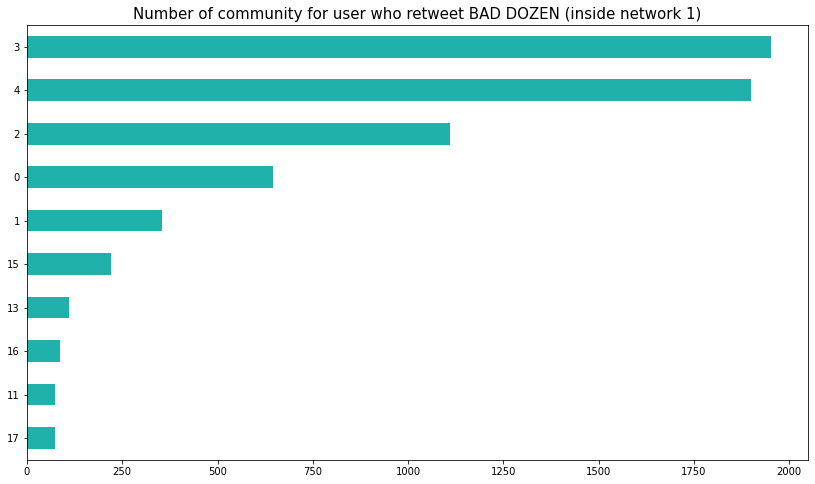

In [14]:
val = rt_community(ccdh_rt_flt_1, louvain_1)
print(f"Totale degli utenti che retweettano i Bad Dozen in questa network: {val.sum()}, il {round(val.sum()/comm.sum()*100,2)}%")
print(f"{round(val.sum()/len(ccdh_rt)*100,2)}% su chi retweetta i Bad Dozen")
plot_hist(val, "Number of community for user who retweet BAD DOZEN (inside network 1)")

# print(f"Lunghezza della community più grande: {val[0]} nodi su {comm[3]} della network ({round(val[0]/comm[3],4)*100}%)")
# print(f"La community 1-0 contiene il {round(val[0] / sum(val),4)*100}% degli utenti presenti nella network")
# print(f"La network contiene {sum(val)} utenti che retwettano i BAD DOZEN su un totale di {len(ccdh_rt)} ({round(sum(val)/len(ccdh_rt),2)*100}%)")


Utenti che retweettano i Good Dozen : 24427, il 2.14% sulla network
41.11% sul totale degli utenti che retweettano i Good Dozen


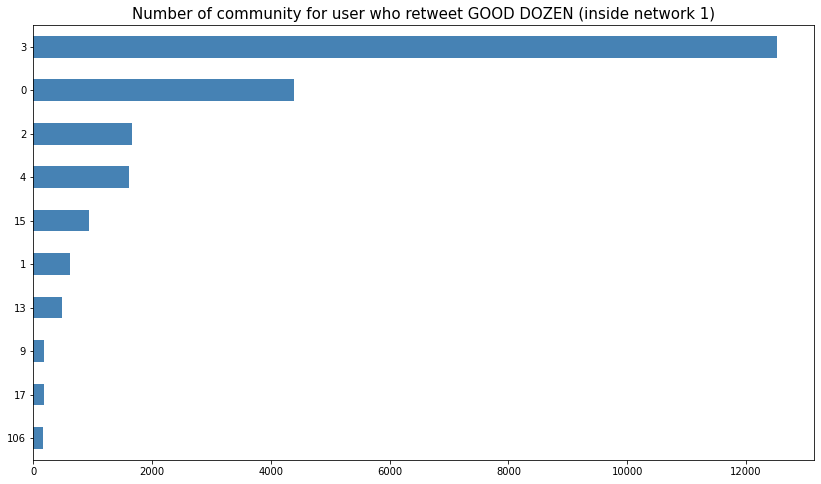

In [15]:
val = rt_community(good_rt_flt_1, louvain_1)
print(f"Utenti che retweettano i Good Dozen : {val.sum()}, il {round(val.sum()/comm.sum()*100,2)}% sulla network")
print(f"{round(val.sum()/len(good_rt)*100,2)}% sul totale degli utenti che retweettano i Good Dozen")
plot_hist(val, "Number of community for user who retweet GOOD DOZEN (inside network 1)", "steelblue")

### Network Community 2
<p>
    
    News meno politiche, più concentrato sulle notizie (maggiori testate al mondo come CNN international,
    BBC world, Time ecc)
    
</p>
<a id="comm_2"/>

In [12]:
path_inside = path + "/network_2/"
louvain_path = glob.glob(path_inside + "louvain*.json")[0]
deg_path = glob.glob(path_inside + "degree.json")[0]
degree_2 = read_from_json(deg_path)
louvain_2 = read_from_json(louvain_path)
ccdh_rt_flt_2 = ccdh_rt[ccdh_rt.user_screen_name.isin([x for x in louvain_2])]
good_rt_flt_2 = good_rt[good_rt.user_screen_name.isin([x for x in louvain_2])]
# to_remove = ccdh_rt[~ccdh_rt.user_screen_name.isin([x for x in louvain_2])]

Time:  2.0055139000000963
Time:  1.3193107000001874


In [19]:
nt_2_users = list(louvain_2.keys())
result = []
importlib.reload(tweets_utils)
start_time = time.perf_counter()
j = 0
df_nt2 = pd.DataFrame()
cols_tweets = ["user_screen_name", "text"]
for filename in tqdm(files_tweets):
    print(f"Reading file: {filename}")
    result.extend(tweets_utils.process_all_data(filename, cols_tweets, True, nt_2_users))
    lista = result[j]
    j = j + 1
    print(f"Mese numero {j}")
    for i in range(len(lista)):
        df_nt2 = df_nt2.append(lista[i]["df"])
stop_time = time.perf_counter()
print("Time: ",stop_time-start_time)

In [21]:
# df_nt2

In [17]:
df_nt2.to_csv("C:/Users/gianl/Desktop/Gi/Supsi/BachelorProject/sage/data/nt_2_txt.csv",
              line_terminator="\n", encoding="utf-8", index=False)

#### Info
<a id="info_2">

<p>
    
    Graph with 1036651 nodes and 4312473 edges
    
</p>

#### Louvain
<a id="louvain_2"/>

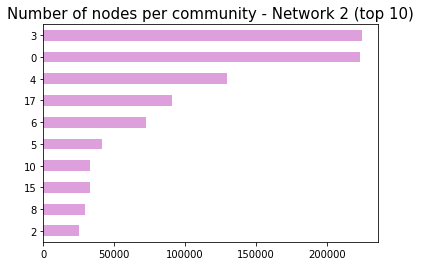

le prime 5 subcommunities sono il 71.57% del totale nella network_1
il numero di utenti è 1036651


In [13]:
communities = []
for i in louvain_2:
    communities.append(louvain_2.get(i))
comm = pd.Series(communities).value_counts().sort_values(ascending=False)
ax = comm[:10].plot(kind='barh', color='plum') #orange #lightseagreen
ax.set_title('Number of nodes per community - Network 2 (top 10)', fontsize=15)
ax.invert_yaxis()
plt.show()
s = 0
for i in comm[:5]:
    s = s + i 
print(f"le prime 5 subcommunities sono il {round(s/comm.sum()*100,2)}% del totale nella network_1")
print(f"il numero di utenti è {comm.sum()}")

### Dozen inside community 2

In [11]:
print("Bad dozen:")
for i in louvain_2:
    if i in list(bad_dozen["screen_name"]):
        print(i)
        print(louvain_2.get(
            i))
print("---------------")
print("Good dozen:")
for i in louvain_2:
    if i in list(good_dozen["screen_name"]):
        print(i)
        print(louvain_2.get(i))

Bad dozen:
unhealthytruth
6
BusyDrT
6
RobertKennedyJr
6
mercola
6
kevdjenkins1
6
DrButtar
6
DrChrisNorthrup
6
---------------
Good dozen:
trvrb
3
CDCDirector
3
MackayIM
3
DrEricDing
3
IlonaKickbusch
3
kakape
3
mlipsitch
3


### Subcommunities

In [83]:
lst_3 = []
lst_6 = []
lst_0 = []
lst_4 = []
lst_17 = []

for i in louvain_2:
    if louvain_2.get(i) == 3:
        lst_3.append(i)
    if louvain_2.get(i) == 6:
        lst_6.append(i)
    if louvain_2.get(i) == 0:
        lst_0.append(i)
    if louvain_2.get(i) == 4:
        lst_4.append(i)
    if louvain_2.get(i) == 17:
        lst_17.append(i)

In [84]:
df_info = df_info.append(df_from_degree(degree=degree_2, lst_subcomm=lst_3, community=2, subcomm=3))
df_info = df_info.append(df_from_degree(degree=degree_2, lst_subcomm=lst_6, community=2, subcomm=6))
df_info = df_info.append(df_from_degree(degree=degree_2, lst_subcomm=lst_0, community=2, subcomm=0))
df_info = df_info.append(df_from_degree(degree=degree_2, lst_subcomm=lst_4, community=2, subcomm=4))
df_info = df_info.append(df_from_degree(degree=degree_2, lst_subcomm=lst_17, community=2, subcomm=17))
df_info = df_info.reset_index(drop=True)

Reuters -> business news
business -> business news
BNODesk -> news
Quicktake -> business news
AFP -> france news

BorisJohnson -> uk prime minister (cons)
PeterSweden7 -> swedish journalist
Telegraph -> uk newspaper
RitaPanahi -> australian journalist (cons)
Nigel_Farage -> uk politcian (cons)

charliekirk11 -> involved in USA politics (cons)
RealJamesWoods -> acotr involved in USA politics (cons)
RealCandaceO -> activist involved in USA politics (cons)
IngrahamAngle -> journalist involved in USA politics (cons)
DonaldJTrumpJr -> politcian (cons)

jenniferatntd -> chinese activist
SenTomCotton -> politcian (cons)
MailOnline -> uk news
badiucao -> chinese cartoonist and activist 
HawleyMO -> politcian (cons)

Karl_Lauterbach -> german politician (dem)
tagesschau -> german news
Tagesspiegel -> german news
ZDFheute -> german news
derspiegel -> german news

Totale degli utenti che retweettano i Bad Dozen in questa network: 48402, il 4.67%
31.52% su chi retweetta i Bad Dozen


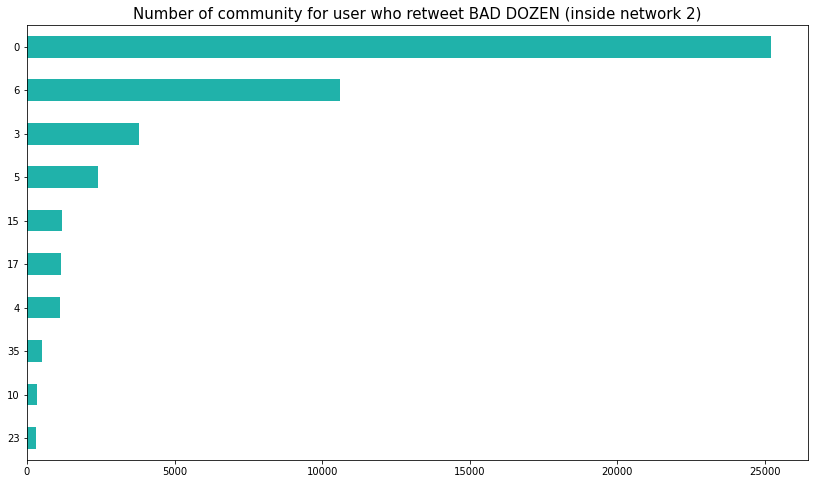

In [18]:
val = rt_community(ccdh_rt_flt_2, louvain_2)
print(f"Totale degli utenti che retweettano i Bad Dozen in questa network: {val.sum()}, il {round(val.sum()/comm.sum()*100,2)}%")
print(f"{round(val.sum()/len(ccdh_rt)*100,2)}% su chi retweetta i Bad Dozen")
# print(f"Lunghezza della community più grande: {val[1]} nodi su {comm[4]} della network ({round(val[1]/comm[4],4)*100}%)")
# print(f"La community 2-1 contiene il {round(val[1] / sum(val),4)*100}% degli utenti presenti nella network")
# print(f"La network contiene {sum(val)} utenti che retwettano i BAD DOZEN su un totale di {len(ccdh_rt)} ({round(sum(val)/len(ccdh_rt),2)*100}%)")
plot_hist(val, "Number of community for user who retweet BAD DOZEN (inside network 2)")

Utenti che retweettano i Good Dozen : 8240, il 0.79% sulla network
13.87% sul totale degli utenti che retweettano i Good Dozen


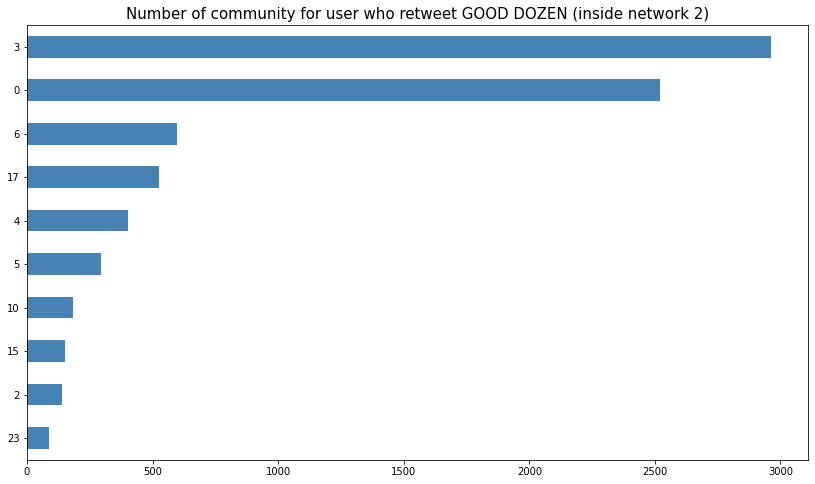

In [19]:
val = rt_community(good_rt_flt_2, louvain_2)
print(f"Utenti che retweettano i Good Dozen : {val.sum()}, il {round(val.sum()/comm.sum()*100,2)}% sulla network")
print(f"{round(val.sum()/len(good_rt)*100,2)}% sul totale degli utenti che retweettano i Good Dozen")
plot_hist(val, "Number of community for user who retweet GOOD DOZEN (inside network 2)", "steelblue")

### Network Community 19
<a id="comm_19"/>


In [11]:
path_inside = path + "/network_19/"
louvain_path = glob.glob(path_inside + "louvain*.json")[0]
degree_path = glob.glob(path_inside + "degree*.json")[0]
degree_19 = read_from_json(degree_path)
louvain_19 = read_from_json(louvain_path)
ccdh_rt_flt_19 = ccdh_rt[ccdh_rt.user_screen_name.isin([x for x in louvain_19])]
good_rt_flt_19 = good_rt[good_rt.user_screen_name.isin([x for x in louvain_19])]

Time:  1.106307600000008
Time:  0.7419964999999991


In [14]:
nt_19_users = list(louvain_19.keys())
result = []
importlib.reload(tweets_utils)
start_time = time.perf_counter()
j = 0
df_nt19 = pd.DataFrame()
cols_tweets = ["user_screen_name", "text"]
for filename in tqdm(files_tweets):
    print(f"Reading file: {filename}")
    result.extend(tweets_utils.process_all_data(filename, cols_tweets, True, nt_19_users))
    lista = result[j]
    j = j + 1
    print(f"Mese numero {j}")
    for i in range(len(lista)):
        df_nt19 = df_nt19.append(lista[i]["df"])
    print(len(df_nt19))
stop_time = time.perf_counter()
print("Time: ",stop_time-start_time)

In [15]:
# df_nt19

In [16]:
df_nt19.to_csv("C:/Users/gianl/Desktop/Gi/Supsi/BachelorProject/sage/data/nt_19_txt.csv",
              line_terminator="\n", encoding="utf-8", index=False)

#### Info
<a id="info_19"/>

<p>
    
    Graph with 607295 nodes and 1479294 edges
    
</p>

#### Louvain
<a id="louvain_19"/>

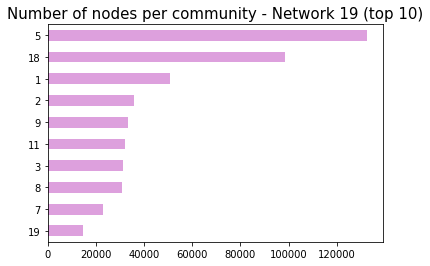

le prime 5 subcommunities sono il 57.73% del totale nella network_1
il numero di utenti è 607295


In [15]:
communities = []
for i in louvain_19:
    communities.append(louvain_19.get(i))
comm = pd.Series(communities).value_counts().sort_values(ascending=False)
ax = comm[:10].plot(kind='barh', color='plum') #orange #lightseagreen
ax.set_title('Number of nodes per community - Network 19 (top 10)', fontsize=15)
ax.invert_yaxis()
plt.show()
s = 0
for i in comm[:5]:
    s = s + i 
print(f"le prime 5 subcommunities sono il {round(s/comm.sum()*100,2)}% del totale nella network_1")
print(f"il numero di utenti è {comm.sum()}")

### Subcommunities

### Dozen inside community 19

In [19]:
for i in louvain_19:
    if i in list(good_dozen["screen_name"]) or i in list(bad_dozen["screen_name"]):
        print(i)
        print(louvain_19.get(i))

DrTedros
3


In [102]:
lst_5 = []
lst_18 = []
lst_1 = []
lst_2 = []
lst_3 = []
for i in louvain_19:
    if louvain_19.get(i) == 5:
        lst_5.append(i)
    if louvain_19.get(i) == 18:
        lst_18.append(i)
    if louvain_19.get(i) == 1:
        lst_1.append(i)
    if louvain_19.get(i) == 2:
        lst_2.append(i)
    if louvain_19.get(i) == 3:
        lst_3.append(i) 
        
df_info = df_info.append(df_from_degree(degree=degree_19, lst_subcomm=lst_5, community=19, subcomm=5))
df_info = df_info.append(df_from_degree(degree=degree_19, lst_subcomm=lst_18, community=19, subcomm=18))
df_info = df_info.append(df_from_degree(degree=degree_19, lst_subcomm=lst_1, community=19, subcomm=1))
df_info = df_info.append(df_from_degree(degree=degree_19, lst_subcomm=lst_2, community=19, subcomm=2))
df_info = df_info.append(df_from_degree(degree=degree_19, lst_subcomm=lst_3, community=19, subcomm=3))
df_info = df_info.reset_index(drop=True)
# df_info

NCDCgov -> nigerian government
DrOlufunmilayo -> nigerian doctor 
aproko_doctor -> nigerian doctor
MobilePunch -> nigerian news
segalink -> nigerian activist

News24 -> southafrican news 
AdvoBarryRoux -> southafrican advocate (suspended)
DrZweliMkhize -> southafrican health minister
eNCA -> african news
MbuyiseniNdlozi -> southafrican politician

citizentvkenya -> kenya news
NationBreaking -> african news
samirasawlani -> journalist
NationAfrica -> african news
RobertAlai -> african politician

UN -> organization
UNICEF -> organization
antonioguterres -> un segretary
UN_Women -> organization
WorldBank -> organization

WHO -> organization
DrTedros -> who director
WHOAFRO -> organization
WebMD -> orgnization
WHOEMRO ->organization

Totale degli utenti che retweettano i Bad Dozen in questa network: 1619, il 0.27%
1.05% su chi retweetta i Bad Dozen


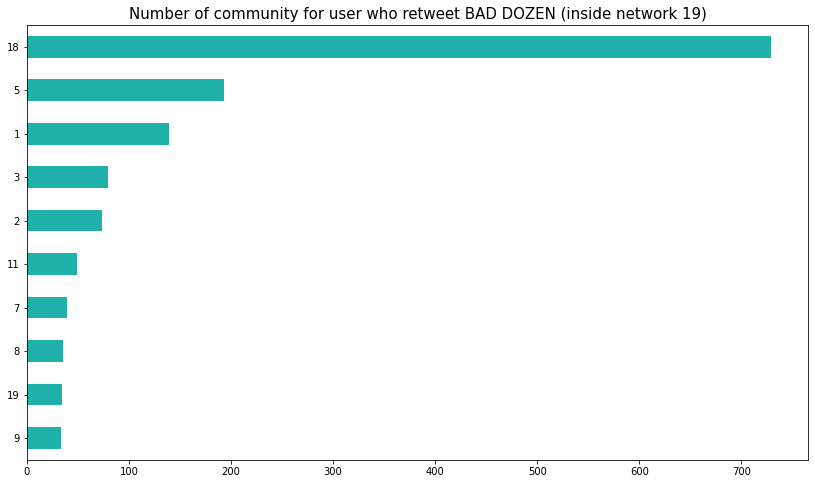

In [15]:
val = rt_community(ccdh_rt_flt_19, louvain_19)
print(f"Totale degli utenti che retweettano i Bad Dozen in questa network: {val.sum()}, il {round(val.sum()/comm.sum()*100,2)}%")
print(f"{round(val.sum()/len(ccdh_rt)*100,2)}% su chi retweetta i Bad Dozen")
# print(f"Lunghezza della community più grande: {val[1]} nodi su {comm[4]} della network ({round(val[1]/comm[4],4)*100}%)")
# print(f"La community 2-1 contiene il {round(val[1] / sum(val),4)*100}% degli utenti presenti nella network")
# print(f"La network contiene {sum(val)} utenti che retwettano i BAD DOZEN su un totale di {len(ccdh_rt)} ({round(sum(val)/len(ccdh_rt),2)*100}%)")
plot_hist(val, "Number of community for user who retweet BAD DOZEN (inside network 19)")

Utenti che retweettano i Good Dozen : 482, il 0.08% sulla network
0.81% sul totale degli utenti che retweettano i Good Dozen


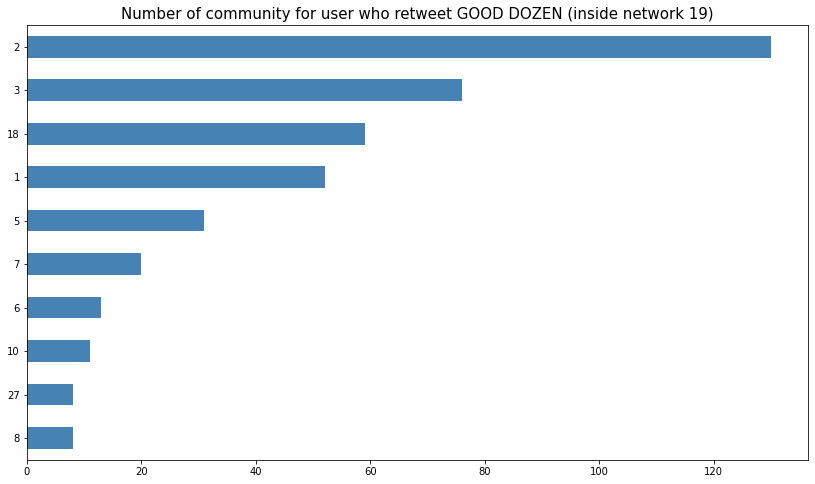

In [16]:
val = rt_community(good_rt_flt_19, louvain_19)
print(f"Utenti che retweettano i Good Dozen : {val.sum()}, il {round(val.sum()/comm.sum()*100,2)}% sulla network")
print(f"{round(val.sum()/len(good_rt)*100,2)}% sul totale degli utenti che retweettano i Good Dozen")
plot_hist(val, "Number of community for user who retweet GOOD DOZEN (inside network 19)", "steelblue")

### Subnetwork DataFrame
<a id="subnet_df"/>

In [5]:
# df = pd.read_csv("C:/Users/gianl/Desktop/Gi/Supsi/BachelorProject/csv/subcommunities_w_desc.csv", lineterminator="\n", low_memory=False)
df[df["community"]==19]
# df

,name,degree,community,subcommunity,description
50,NCDCgov,21397,19,5,nigerian government
51,DrOlufunmilayo,14401,19,5,nigerian doctor
52,aproko_doctor,7662,19,5,nigerian doctor
53,MobilePunch,6605,19,5,nigerian news
54,segalink,6536,19,5,nigerian activist
55,News24,7078,19,18,southafrican news
56,AdvoBarryRoux,5702,19,18,southafrican advocate (suspended)
57,DrZweliMkhize,5498,19,18,southafrican health minister
58,eNCA,3132,19,18,african news
59,MbuyiseniNdlozi,2974,19,18,southafrican politician


### SAGE
<a id="sage"/>

In [12]:
df_sage = tweets_utils.clean_data_format(df_sage) 
source = [(lambda x: x.split("\\")[5].split("_")[1])(x) for x in df_sage["source"]]
df_sage["source"] = source
df_sage

,source,word,sage,file_count,file_rate,base_count,base_rate
0,19,katika,2.657505,4600,0.000127,4632,0.000014
1,19,ugonjwa,2.654325,3470,0.000096,3505,0.000010
2,19,kebbi,2.654263,6029,0.000167,6091,0.000018
3,19,luth,2.653919,4448,0.000123,4495,0.000013
4,19,kwara,2.653864,13534,0.000374,13680,0.000040
...,...,...,...,...,...,...,...
145,2,quarant,0.984149,8626,0.000064,8717,0.000025
146,2,nahmen,0.984142,15227,0.000113,15389,0.000045
147,2,abstand,0.984104,4145,0.000031,4188,0.000012
148,2,jemand,0.984078,3304,0.000024,3338,0.000010


In [13]:
df_sage[df_sage["source"]=="1"][:10]

,source,word,sage,file_count,file_rate,base_count,base_rate
50,1,wtpteam,0.997636,9932,0.000058,9959,0.000029
51,1,wtp2020,0.996970,7208,0.000042,7232,0.000021
52,1,onevoice1,0.996847,24178,0.000141,24265,0.000071
53,1,loaners,0.994614,3983,0.000023,4005,0.000012
54,1,presidementia,0.994493,4234,0.000025,4258,0.000012
55,1,demcast,0.994133,3838,0.000022,3861,0.000011
56,1,gojoe,0.994089,4277,0.000025,4303,0.000013
57,1,commutations,0.993232,3636,0.000021,3661,0.000011
58,1,subtraction,0.992858,7234,0.000042,7288,0.000021
59,1,theresistance,0.992322,7976,0.000047,8040,0.000023


In [14]:
df_sage[df_sage["source"]=="2"][:10]

,source,word,sage,file_count,file_rate,base_count,base_rate
100,2,freeiran2020,0.991799,4179,0.000031,4190,0.000012
101,2,hkpolice,0.991432,6941,0.000051,6963,0.000020
102,2,killercuomo,0.991132,4769,0.000035,4785,0.000014
103,2,hongkongpolice,0.990977,3549,0.000026,3561,0.000010
104,2,hkpoliceterrorists,0.989699,3248,0.000024,3263,0.000010
105,2,standwithhk,0.989540,8789,0.000065,8834,0.000026
106,2,antifaterrorists,0.988956,3684,0.000027,3704,0.000011
107,2,hkgov,0.988902,8177,0.000060,8224,0.000024
108,2,carrielam,0.988854,14616,0.000108,14702,0.000043
109,2,standwithhongkong,0.988609,9874,0.000073,9934,0.000029


In [15]:
df_sage[df_sage["source"]=="19"][:10]

,source,word,sage,file_count,file_rate,base_count,base_rate
0,19,katika,2.657505,4600,0.000127,4632,0.000014
1,19,ugonjwa,2.654325,3470,0.000096,3505,0.000010
2,19,kebbi,2.654263,6029,0.000167,6091,0.000018
3,19,luth,2.653919,4448,0.000123,4495,0.000013
4,19,kwara,2.653864,13534,0.000374,13680,0.000040
5,19,sasa,2.653782,4483,0.000124,4531,0.000013
6,19,vya,2.653497,6592,0.000182,6665,0.000019
7,19,kuwa,2.653471,4713,0.000130,4765,0.000014
8,19,watu,2.653208,6425,0.000178,6498,0.000019
9,19,kwa,2.653196,18719,0.000518,18934,0.000055
